# Introduction: Sea Ice Classification from XSAPR data Using CMAC's Fuzzy Logic Algorithm

### Authors : Robert Jackson, Zach Sherman
The X-band ARM Precipitation Radar (XSAPR) at the ARM North Slope of Alaska site provids a unique capability for observing sea ice at high spatial and temporal resolution. Compared with satellite-based retrievals, the XSAPR offers continuous monitoring and the ability to capture rapid ice dynamics such as lead opening, deformation, ridging, melt onset, freeze-up, and interactions with storms. Because these observations are stored in CF-Radial format, they integrate cleanly with the Python ARM Radar Toolkit, allowing standardized access to reflectivity, Doppler velocity, and metadata.

A key challenge, however, is distinguishing sea ice echoes from open-water returns and atmospheric scatterers. Surface returns at X-band are strong but variable: calm water may appear specular and bright (high $Z$); rough water produces streaky, wind-aligned patterns; and sea ice exhibits diffuse, irregular textures. Atmospheric echoes—snow, blowing snow, drizzle—can complicate interpretation further. A simple threshold on reflectivity rarely suffices.

Because of these complexities and nonlinear boundaries between classes, fuzzy logic provides an effective and intuitive approach for building a sea ice mask.

## Pre-requisites to this notebook

The user of this notebook should be familiar with the basic usage of PyART and basic functions for correcting radar data.

1. [PyART basics](https://projectpythia.org/radar-cookbook/notebooks/foundations/pyart-basics/)

2. [PyART Corrections](https://projectpythia.org/radar-cookbook/notebooks/foundations/pyart-corrections/)


## Why Fuzzy Logic for Sea Ice Detection?

Fuzzy logic classifiers are widely used in radar QC (e.g., echo ID, hydrometeor classification, clutter removal) because they:

	•	Handle uncertainty gracefully — ideal for overlapping radar signatures.
	•	Incorporate multiple features such as reflectivity level, reflectivity texture, Doppler velocity variability, and differential reflectivity.
	•	Allow expert knowledge to be encoded through interpretable membership functions and rules.
	•	Produce continuous scores, not just yes/no flags, enabling tuning and probabilistic interpretation.

For sea ice classification, fuzzy logic helps unify at least three key indicators:
	1.	High signal to noise ratio
Ice often produces higher backscatter than open water but overlaps with atmospheric returns.
	2.	Local variability (texture)
Ice fields show heterogeneous backscatter; open water tends to be smoother.
	3.	Velocity stability
Atmospheric echoes often show coherent Doppler structure; surface echoes often show near-zero Doppler or noisy/aliased patterns depending on geometry.

Instead of hard conditional rules, fuzzy logic blends these factors into a sea ice likelihood, generating a flexible and tunable mask.


### Notebook Workflow

This notebook introduces a step-by-step process to build a fuzzy logic sea-ice classifier using XSAPR data:

### 1. Load CF-Radial data

    •	We will use Py-ART to open the dataset and extract the key fields.

### 2. Preprocess the scan

	•	Select the -0.5 degree sweep.

### 3. Compute features for fuzzy inputs

We will generate several scalar fields used as fuzzy inputs:

	•	Signal to noise ratio
 
	•	Texture of radial velocity 
 
	•	Sounding temperatures
 
	•	Spectral width

These features are normalized and scaled appropriately.

### 4. Define fuzzy membership functions

For each feature, we create membership functions for the following inputs:

    •	Signal to noise ratio
    •	Texture of radial velocity
    •	Cross-correlation coefficient
    •	Normalized Coherent Power
    •	Spectral Width
    •	Differential Reflectivity

We classify each gate into six categories: Melting layer, rain, snow, no scatterer, multi-trip, sea ice, sea clutter. We will visualize each membership function and describe how its shape corresponds to physical intuition.

### 5. Combine features using hard constraints

Examples:

	•	If the height is above 200 m, its precipitation

The rules produce an aggregated sea ice score between 0 and 1.

### 6. Defuzzify to produce a binary sea ice mask

A tunable threshold (e.g., 0.5) yields:

	•	1 → sea ice
	•	0 → non-ice (open water or atmosphere)

We will also demonstrate how adjusting the threshold affects classification.

### 7. Visualize and evaluate the mask

Plots will include:

	•	PPI reflectivity
	•	Feature maps
	•	Mask overlays over NASA Sentinel-1 data
	•	Final sea ice mask


### Goals of This Notebook

By the end, you will understand:

	•	How to load and manipulate XSAPR data in Python
	•	Which radar features best separate sea ice from other echo types
	•	How fuzzy logic can encode interpretable physical heuristics
	•	How to build and tune a fuzzy classifier for marine remote sensing applications
	•	How to visualize and validate the resulting sea ice mask

This framework is also extensible: additional features can be added easily.


# Import necessary packages
We will be importing several libraries that are needed for the analysis. The core packages that this analysis depends on:

* [Python ARM Radar Toolkit](https://arm-doe.github.io/pyart/)
* [cmweather](https://cmweather.readthedocs.io/en/stable/)
* [Matplotlib](https://matplotlib.org/)
* [NumPy](https://numpy.org/)
* [Scikit-fuzzy](https://pythonhosted.org/scikit-fuzzy/overview.html)
* [Xarray](https://docs.xarray.dev/en/stable/)
* [RasterIO](https://rasterio.readthedocs.io/en/stable/)
* [Pandas](https://pandas.pydata.org/)
* [Cartopy](https://cartopy.readthedocs.io/stable/)
* [SciPy](https://scipy.org/)

In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"]="FALSE"
import act
import pyart
import cmweather
import matplotlib.pyplot as plt
import numpy as np
import glob
import tempfile
import skfuzzy as fuzz
import xarray as xr
import copy
import operator
import rasterio
import xml.etree.ElementTree as ET
import pandas as pd
import cartopy.crs as ccrs

from scipy.signal import convolve2d
from scipy.ndimage import median_filter
from scipy import ndimage
from scipy.interpolate import griddata
from datetime import datetime
from matplotlib import colors, ticker


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## First case -- April 6 2025. 

In this case, both snow and sea ice are visible in the -0.5 degree scan of XSAPR. Therefore, this will provide a good case to see if we can identify sea ice echoes when it is snowing. Let's load the data. 

In [5]:
radar_one = pyart.io.read(
    '/gpfs/wolf2/arm/atm124/proj-shared/nsa/nsaxsaprcfrC1.a1/nsaxsaprcfrC1.a1.20250406.171947.nc')

First, we will look at the reflectivity. The sea ice will show up as a consistent echo right off of the coast.
Sea ice is present in the top left area of the scan, with localized reflectivities of about 20 dBZ.

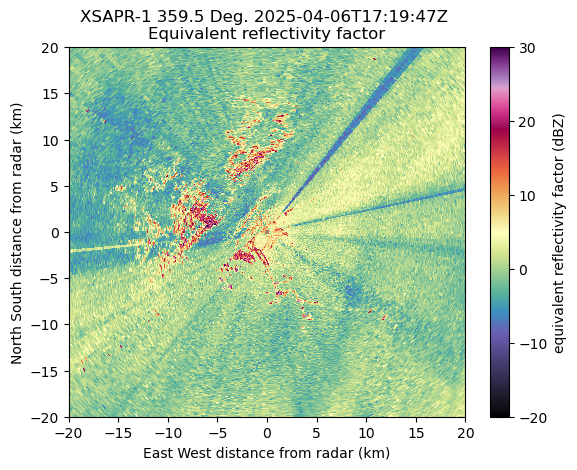

In [18]:
xmin = -20
xmax = 20
ymin = -20
ymax = 20
display = pyart.graph.RadarDisplay(radar_one)
gatefilter = pyart.filters.GateFilter(radar_one)
gatefilter.exclude_invalid('signal_to_noise_ratio')
display.plot_ppi('reflectivity', cmap='ChaseSpectral', vmin=-20, vmax=30,
                 gatefilter=gatefilter)
#display.plot_ppi('gate_id', 0, mask_tuple=('gate_id', 5), cmap='Greys', alpha=1)
#plt.axis('off')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.savefig('radar_refl.png')

Let's take a look at the radial velocity. The sea ice will have a much different radial velocity than the precipitation, as it will be moving with the flow of the sea instead of the air. Spectral widths will also be much lower for sea ice than for precipitation as the sea ice has a more homogeneous velocity throughout the radar scattering cross section than the precipitation. 

Finally, we should expect a signature in differential reflectivity from sea ice. The thicker the sea ice, the more negative the ZDR will be because the vertical thickness will start to exceed the lateral thicknness of the sea ice. This corresponds to a much higher reflectivity in the vertical polarization than in the horizontal polarization, producing negative ZDR values.

For thin sea ice, ZDR may even go positive as the lateral coverage would be much greater than the vertical thickness. In this case, the reflectivity in the horizontal polarization would be much greater than the vertical.

Here, the radial velocity in the sea ice is close to zero, and vastly different from the precipitation.

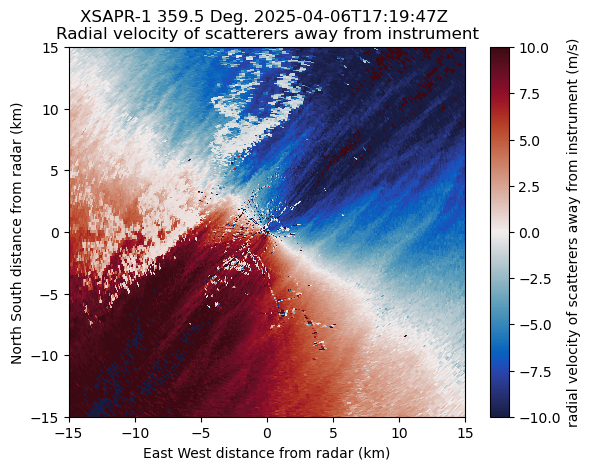

In [9]:
xmin = -15
xmax = 15
ymin = -15
ymax = 15
display = pyart.graph.RadarDisplay(radar_one)
gatefilter = pyart.filters.GateFilter(radar_one)
#gatefilter.exclude_above('spectral_width',1.2)
display.plot_ppi('mean_doppler_velocity', cmap='balance', vmin=-10, vmax=10,
                 gatefilter=gatefilter)
#display.plot_ppi('gate_id', 0, mask_tuple=('gate_id', 5), cmap='Greys', alpha=1)
#plt.axis('off')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.savefig('radar_velocity.png')

Let's look at cross-correlation ratio $\rho_{hv}$. In this case, the sea ice echoes have variable $\rho_{hv}$, anywhere from 0.4 to 1, showing that the distribution of shapes can vary widely in the sea ice.

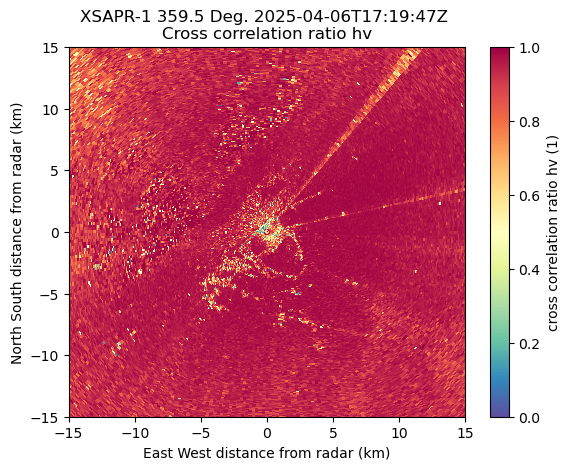

In [13]:
xmin = -15
xmax = 15
ymin = -15
ymax = 15
display = pyart.graph.RadarDisplay(radar_one)
gatefilter = pyart.filters.GateFilter(radar_one)
display.plot_ppi('cross_correlation_ratio_hv', cmap='Spectral_r', vmin=0, vmax=1,
                 gatefilter=gatefilter)
#plt.axis('off')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

Let's look at differential reflectivity $Z_{DR}$. In this case, the sea ice echoes have negative $Z_{DR}$, anywhere from -10 to -2 dB, showing that the thick sea ice is strongly oriented perpendicular to the beam.

(-15.0, 15.0)

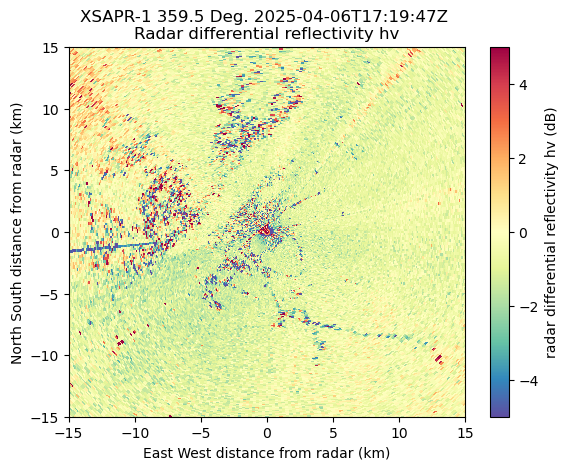

In [22]:
xmin = -15
xmax = 15
ymin = -15
ymax = 15
display = pyart.graph.RadarDisplay(radar_one)
gatefilter = pyart.filters.GateFilter(radar_one)
display.plot_ppi('differential_reflectivity', cmap='Spectral_r', vmin=-5, vmax=5,
                 gatefilter=gatefilter)
#plt.axis('off')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Corrected Moments in Antenna Coordinates Gate ID

When creating a sea ice mask, one must first filter out the noisy, precipitation, and multi-trip echoes. This can all be done before data processing through fuzzy logic technquies. Corrected Moments in Antenna Coordinates (CMAC) is an ARM Facility Value Added Product that uses a fuzzy logic scheme to filter out non-hydrometeorlogical echoes before data processing in a gate ID function [1]. It works by using a fuzzy logic scheme that classifies gates using different membership functions for each of these specified inputs:

   * Velocity texture --> a measure of velocity variability. High textures indicate noise.
   * $\rho_{hv}$ - Cross-correlation coefficeint. Low values indicate clutter and non-hydrometeors. 
   * Normalized Coherent Power --> A measure of signature coherence, from 0 to 1. Low coherence suggests a multi-trip echo.
   * Gate height --> used to provide a physically realistic constraint
   * Sounding temperature --> used to characterize the melting layer
   * Signal to Noise Ratio --> low SNR tends to be noise
   * Spectral width --> Low spectral width corresponds to sea ice
   * Differential reflectivity --> Negative values can correspond to sea clutter
                  
A sounding is needed for the input temperature field for CMAC. For more details on CMAC's fuzzy logic algorithm, see [1]. The below subroutines are the code for CMAC's fuzzy logic scheme.

### References
[1] Jackson, R., J.R. O’Brien, M. Grover, Z. Sherman, S. Collis, B.A. Raut, M. Tuftedal, A. Theisen, D. Feldman, W. Rudisill, V. Chandrasekar, 2025: Surface Quantitative Precipitation Estimates (SQUIRE) of snow water equivalent from the Surface Atmospheric Integrated Laboratory, J. Atmospheric and Oceanic Technology, in press, [doi:10.1175/JTECH-D-25-0023.1](https://doi.org/10.1175/JTECH-D-25-0023.1)


In [7]:
# Moment : [[start_up, finish_up, start_down, finish_down], weight]
def cum_score_fuzzy_logic(radar, mbfs=None,
                          ret_scores=False,
                          hard_const=None,
                          verbose=False):
    """
    This function provides a fuzzy logic score given a radar object
    and a membership function.

    Parameters
    ----------
    radar: PyART radar object
        The radar object to perform the fuzzy logic algorithm on.
    mbfs: dict
        A dictionary with the membership functions. The keys are the input variables.
        The values are a nested list, with the format of
        [[start_up, finish_up, start_down, finish_down], weight]
        where
            start_up = the value where the start of the line going up to the weight is
            end_up = the value where the end of the line going up to the weight is
            start_down = the value where the start of the line going down from the weight is
            end_down = the value where the end of the line going down from the weight is
        Between end_up and start_down, the membership function takes on the value specified
        by the weight.
    ret_scores: bool
        Set to true to return the scores
    hard_const: list
        A list of format [[class, field, (v1, v2)], ...] where each element [class, field, (v1, v2)] specifies:
            class = the gate ID class name
            field = the field where to base the hard constraint
            v1 = lower bound on field
            v2 = upper bound on field
        The class value will always be zero if the field is in between v1 and v2.
    verbose: bool
        If True, print debug output.

    Returns
    -------
    gid: dict
         The gate ID in a Py-ART field compatible dictionary
    categories: list of str
         The name of each category.
    scores: list of floats
         The score corresponding to each category.
    """
                              
    if mbfs is None:
        second_trip = {'velocity_texture': [[0, 0, 1.8, 2], 1.0],
                       'cross_correlation_ratio': [[.5, .7, 1, 1], 0.0],
                       'normalized_coherent_power': [[0, 0, .5, .6], 3.0],
                       'height': [[0, 0, 5000, 8000], 1.0],
                       'sounding_temperature': [[-100, -100, 100, 100], 0.0],
                       'signal_to_noise_ratio': [[15, 20, 1000, 1000], 1.0]}

        rain = {'differential_phase_texture': [[0, 0, 80, 90], 1.0],
                'cross_correlation_ratio': [[0.94, 0.96, 1, 1], 1.0],
                'normalized_coherent_power': [[0.4, 0.5, 1, 1], 1.0],
                'height': [[0, 0, 5000, 6000], 0.0],
                'sounding_temperature': [[0, 3, 100, 100], 2.0],
                'signal_to_noise_ratio': [[8, 10, 1000, 1000], 1.0]}

        snow = {'differential_phase_texture': [[0, 0, 80, 90], 1.0],
                'cross_correlation_ratio': [[0.85, 0.9, 1, 1], 1.0],
                'normalized_coherent_power': [[0.4, 0.5, 1, 1], 1.0],
                'height': [[0, 0, 25000, 25000], 0.0],
                'sounding_temperature': [[-100, -100, 0, 1.], 2.0],
                'signal_to_noise_ratio': [[8, 10, 1000, 1000], 1.0]}

        no_scatter = {'differential_phase_texture': [[90, 90, 400, 400], 0.0],
                      'cross_correlation_ratio': [[0, 0, 0.1, 0.2], 0.0],
                      'normalized_coherent_power': [[0, 0, 0.1, 0.2], 0.0],
                      'height': [[0, 0, 25000, 25000], 0.0],
                      'sounding_temperature': [[-100, -100, 100, 100], 0.0],
                      'signal_to_noise_ratio': [[-100, -100, 8, 10], 6.0]}

        melting = {'differential_phase_texture': [[20, 30, 80, 90], 0.0],
                   'cross_correlation_ratio': [[0.6, 0.7, .94, .96], 4.],
                   'normalized_coherent_power': [[0.4, 0.5, 1, 1], 0],
                   'height': [[0, 0, 25000, 25000], 0.0],
                   'sounding_temperature': [[-1., 0, 3.5, 5], 2.],
                   'signal_to_noise_ratio': [[8, 10, 1000, 1000], 0.0]}

        mbfs = {'multi_trip': second_trip, 'rain': rain, 'snow': snow,
                'no_scatter': no_scatter, 'melting': melting}

    flds = radar.fields
    scores = {}
    for key in mbfs.keys():
        if verbose:
            print('##    Doing', key)
        this_score = np.zeros(
            flds[list(flds.keys())[0]]['data'].shape).flatten() * 0.0
        for MBF in mbfs[key].keys():
            this_score = fuzz.trapmf(
                flds[MBF]['data'].flatten(),
                mbfs[key][MBF][0]) * mbfs[key][MBF][1] + this_score

        this_score = this_score.reshape(
            flds[list(flds.keys())[0]]['data'].shape)
        scores.update({key: ndimage.filters.median_filter(
            this_score, size=[3, 4])})

    if hard_const is not None:
        # hard_const = [[class, field, (v1, v2)], ...]
        for this_const in hard_const:
            if verbose:
                print('##    Doing hard constraining', this_const[0])
            key = this_const[0]
            const = this_const[1]
            fld_data = radar.fields[const]['data']
            lower = this_const[2][0]
            upper = this_const[2][1]
            const_area = np.where(np.logical_and(fld_data >= lower,
                                                 fld_data <= upper))
            if verbose:
                print('##    ', str(const_area))
            scores[key][const_area] = 0.0
        
        # No sea ice for > 2 degree elevation scans (NSA only)
        if 'sea_ice' in mbfs.keys():
            no_sea_ice = np.where(radar.elevation["data"] > 2.)
            scores['sea_ice'][no_sea_ice, :] = 0.0
        if 'sea_clutter' in mbfs.keys():
            no_sea_ice = np.where(radar.elevation["data"] > 2.)
            scores['sea_clutter'][no_sea_ice, :] = 0.0
    stacked_scores = np.dstack([scores[key] for key in scores.keys()])
    max_score = stacked_scores.argmax(axis=2)

    gid = {}
    gid['data'] = max_score
    gid['units'] = ''
    strgs = ''
    i = 0
    for key in scores.keys():
        strgs = strgs + str(i) + ':' + key + ','
        i = i + 1
    gid['long_name'] = 'Classification of dominant scatterer'
    gid['notes'] = strgs[0:-1]
    gid['valid_max'] = max_score.max()
    gid['valid_min'] = 0.0

    if ret_scores is False:
        rv = (gid, scores.keys())
    else:
        rv = (gid, scores.keys(), scores)
    return rv

# This is the main function
def do_my_fuzz(radar, rhv_field, ncp_field,
               tex_start=2.0, tex_end=2.1,
               custom_mbfs=None, custom_hard_constraints=None,
               verbose=True):  
    """
    This is the main function for the fuzzy logic algorithm.
    This function provides a fuzzy logic score given a radar object
    and a membership function.

    Parameters
    ----------
    radar: PyART radar object
        The radar object to perform the fuzzy logic algorithm on.
    rhv_field: str
        The name of the cross correlation coefficient field (rho_hv).
    ncp_field: str
        The name of the normalized coherent power field.
    tex_start: float
        The starting texture for considering noise or second-trip echoes.
        Velocity texture thresholds may need adjusted according to the radar being used.
    tex_end: float
        The membership function for non-hydrometeors will be the weight after this texture.
    custom_mbfs: dict or None
        A dictionary with the membership functions. The keys are the input variables.
        The values are a nested list, with the format of
        [[start_up, finish_up, start_down, finish_down], weight]
        where
            start_up = the value where the start of the line going up to the weight is
            end_up = the value where the end of the line going up to the weight is
            start_down = the value where the start of the line going down from the weight is
            end_down = the value where the end of the line going down from the weight is
        Between end_up and start_down, the membership function takes on the value specified
        by the weight.
        If None, CMAC's default membership functions are used.
    custom_hard_constraints: list
        A list of format [[class, field, (v1, v2)], ...] where each element [class, field, (v1, v2)] specifies:
            class = the gate ID class name
            field = the field where to base the hard constraint
            v1 = lower bound on field
            v2 = upper bound on field
        The class value will always be zero if the field is in between v1 and v2.
    verbose: bool
        If True, print debug output.

    Returns
    -------
    out_radar: PyART radar object
         The radar object containing the Gate IDs.
    """
    if verbose:
        print('##')
        print('## CMAC calculation using fuzzy logic:')

    second_trip = {'velocity_texture': [[tex_start, tex_end, 130., 130.], 4.0],
                   rhv_field: [[.5, .7, 1, 1], 0.0],
                   ncp_field: [[0, 0, .5, .6], 1.0],
                   'height': [[0, 0, 5000, 8000], 0.0],
                   'sounding_temperature': [[-100, -100, 100, 100], 0.0],
                   'signal_to_noise_ratio': [[8, 10, 1000, 1000], 1.0],
                   'spectral_width': [[-10, 0, 1, 10], 0.0],
                   'differential_reflectivity': [[-10, 0, 10, 30], 0.0]}

    rain = {'velocity_texture': [[0, 0, tex_start, tex_end], 1.0],
            rhv_field: [[0.97, 0.98, 1, 1], 1.0],
            ncp_field: [[0.4, 0.5, 1, 1], 1.0],
            'height': [[0, 0, 5000, 6000], 0.0],
            'sounding_temperature': [[2., 5., 100, 100], 2.0],
            'signal_to_noise_ratio': [[8, 10, 1000, 1000], 1.0],
                   'spectral_width': [[-10, 0, 1, 10], 0.0],
                   'differential_reflectivity': [[-10, 0, 10, 30], 0.0]}

    snow = {'velocity_texture': [[0, 0, tex_start, tex_end], 1.0],
            rhv_field: [[0.65, 0.9, 1, 1], 1.0],
            ncp_field: [[0.4, 0.5, 1, 1], 1.0],
            'height': [[0, 0, 25000, 25000], 0.0],
            'sounding_temperature': [[-100, -100, .5, 4.], 2.0],
            'signal_to_noise_ratio': [[8, 10, 1000, 1000], 1.0],
                   'spectral_width': [[0.6, 0.65, 1000, 1000], 2.0],
                   'differential_reflectivity': [[-10, 0, 10, 30], 0.0]}

    no_scatter = {'velocity_texture': [[tex_start, tex_end, 330., 330.], 2.0],
                  rhv_field: [[0, 0, 0.1, 0.2], 0.0],
                  ncp_field: [[0, 0, 0.1, 0.2], 0.0],
                  'height': [[0, 0, 25000, 25000], 0.0],
                  'sounding_temperature': [[-100, -100, 100, 100], 0.0],
                  'signal_to_noise_ratio': [[-100, -100, 8, 10], 4.0],
                   'spectral_width': [[-10, 0, 1, 10], 0.0],
                   'differential_reflectivity': [[-10, 0, 10, 30], 0.0]}

    melting = {'velocity_texture': [[0, 0, tex_start, tex_end], 0.0],
               rhv_field: [[0.6, 0.65, .9, .96], 2.0],
               ncp_field: [[0.4, 0.5, 1, 1], 0],
               'height': [[0, 0, 25000, 25000], 0.0],
               'sounding_temperature': [[0, 0.1, 2, 4], 4.0],
               'signal_to_noise_ratio': [[8, 10, 1000, 1000], 0.0],
               'spectral_width': [[-10, 0, 1, 10], 0.0],
               'differential_reflectivity': [[-10, 0, 10, 30], 0.0]}
                   
    sea_ice = {'velocity_texture': [[0, 0, tex_start, tex_end], 0],
               rhv_field: [[0.2, 0.25, 1, 1], 1.0],
               ncp_field: [[0.8, 0.85, 1, 1], 1.0],
               'height': [[0, 0, 25000, 25000], 0.0],
               'sounding_temperature': [[0, 0.1, 2, 4], 0.0],
               'signal_to_noise_ratio': [[8, 10, 1000, 1000], 3.0],
                   'spectral_width': [[0, 0.0001, 0.01, 0.011], 3.0],
                   'differential_reflectivity': [[-10, -9, -2.5, -2], 2.0]}
    sea_clutter = {'velocity_texture': [[0, 0, tex_start, tex_end], 1.0],
                   rhv_field: [[0.2, 0.25, 0.7, 0.75], 2.0],
                   ncp_field: [[0.8, 0.85, 1, 1], 1.0],
                   'height': [[0, 0, 25000, 25000], 0.0],
                   'sounding_temperature': [[0, 0.1, 2, 4], 0.0],
                   'signal_to_noise_ratio': [[8, 10, 1000, 1000], 3.0],
                       'spectral_width': [[0, 0.1, 0.4, 0.45], 2.0],
                       'differential_reflectivity': [[-10, -9, -2.5, -2], 2.0]}

    if custom_mbfs is None:
        mbfs = {'multi_trip': second_trip, 'rain': rain, 'snow': snow,
                'no_scatter': no_scatter, 'melting': melting, 'sea_ice': sea_ice,
               'sea_clutter': sea_clutter}
    else:
        mbfs = custom_mbfs

    if custom_hard_constraints is None:
        hard_const = [['melting', 'sounding_temperature', (10, 100)],
                      ['multi_trip', 'height', (10000, 1000000)],
                      ['melting', 'sounding_temperature', (-10000, -2)],
                      ['rain', 'sounding_temperature', (-1000, -5)],
                      ['melting', 'velocity_texture', (3, 300)],
                      ['sea_ice', 'height', (300, 100000)],
                      ['sea_clutter', 'height', (300, 100000)]]
    else:
        hard_const = custom_hard_constraints

    gid_fld, cats = cum_score_fuzzy_logic(radar, mbfs=mbfs, verbose=verbose,
                                          hard_const=hard_const)
    rain_val = list(cats).index('rain')
    snow_val = list(cats).index('snow')
    melt_val = list(cats).index('melting')
    return _fix_rain_above_bb(gid_fld, rain_val, melt_val, snow_val), cats

# A function to get the melting layer
def get_melt(radar, melt_cat=None):
    """
    This function gets the melting layer height according to the Gate ID and sounding temperatures.

    Parameters
    ----------
    radar: PyART radar object
         The radar object to run the melting layer algorithm on.
    melt_cat: int
         The melting layer category. If None, then it will be retrieved from the radar object.

    Returns
    -------
    fzl: float
         The melting layer height.
    """
    
    if melt_cat is None:
        cat_dict = {}
        for pair_str in radar.fields['gate_id']['notes'].split(','):
            cat_dict.update(
                {pair_str.split(':')[1]: int(pair_str.split(':')[0])})

        melt_cat = cat_dict['melting']

    melt_locations = np.where(radar.fields['gate_id']['data'] == melt_cat)
    kinda_cold = np.where(radar.fields['sounding_temperature']['data'] < 0)
    try:
        fzl_sounding = radar.gate_altitude['data'][kinda_cold].min()
        if len(melt_locations[0] > 1):
            fzl_pid = radar.gate_altitude['data'][melt_locations].min()
            fzl = (fzl_pid + fzl_sounding) / 2.0
        else:
            fzl = fzl_sounding
    except ValueError:
        fzl = 3500.0

    print(fzl)
    if fzl > 5000:
        fzl = 3500.0
    if fzl < 1000:
        fzl = radar.gate_altitude['data'].min()
    return fzl

def fix_phase_fields(orig_kdp, orig_phidp, rrange, happy_kdp,
                     max_kdp=15.0):

    orig_kdp['data'][happy_kdp.gate_excluded] = 0.0
    orig_kdp['data'][orig_kdp['data'] > max_kdp] = max_kdp
    interg = integrate.cumtrapz(orig_kdp['data'], rrange, axis=1)
    print(interg.shape)
    print(orig_phidp['data'].shape)
    orig_phidp['data'][:, 0:-1] = interg/len(rrange)
    return orig_phidp, orig_kdp

def _fix_rain_above_bb(gid_fld, rain_class, melt_class, snow_class):
    print(snow_class)
    new_gid = copy.deepcopy(gid_fld)
    for ray_num in range(new_gid['data'].shape[0]):
        if melt_class in new_gid['data'][ray_num, :]:
            max_loc = np.where(
                new_gid['data'][ray_num, :] == melt_class)[0].max()
            rain_above_locs = np.where(
                new_gid['data'][ray_num, max_loc:] == rain_class)[0] + max_loc
            new_gid['data'][ray_num, rain_above_locs] = snow_class
    return new_gid


def _extract_unmasked_data(radar, field, bad=-32768):
    """ Simplify getting unmasked radar fields from Py-ART. """
    return radar.fields[field]['data'].filled(fill_value=bad)

For the sounding we will use the regular sounding launches at the North Slope of Alaska Central Facility (C1) We will load the rawinsonde data and then use input into CMAC's gate id.

In [39]:
# Load the sounding data
sonde = xr.open_dataset('/gpfs/wolf2/arm/atm124/proj-shared/nsa/nsasondewnpnC1.b1/nsasondewnpnC1.b1.20250406.172900.cdf')
tdry = sonde.variables["tdry"][:]
alt = sonde.variables["alt"][:]
tdry = np.insert(tdry, 0, tdry[0])
alt = np.insert(alt, 0, -9999.)

# Map the sounding data to antenna coordinates
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(
        tdry, alt, radar_one)
 
radar_one.fields["height"] = z_dict
radar_one.fields["sounding_temperature"] = temp_dict

# Retrieve the velocity texture needed by the Gate ID
texture = pyart.retrieve.calculate_velocity_texture(radar_one, vel_field="mean_doppler_velocity")
radar_one.fields["velocity_texture"] = texture

# Run the fuzzy logic algorithm
gate_id, _ = do_my_fuzz(radar_one, 'cross_correlation_ratio_hv', 'normalized_coherent_power')
gate_id

# Add the Gate ID field to the radar object
radar_one.fields["gate_id"] = gate_id

##
## CMAC calculation using fuzzy logic:
##    Doing multi_trip
##    Doing rain
##    Doing snow
##    Doing no_scatter
##    Doing melting
##    Doing sea_ice
##    Doing sea_clutter
##    Doing hard constraining melting
##     (array([], dtype=int64), array([], dtype=int64))
##    Doing hard constraining multi_trip
##     (array([], dtype=int64), array([], dtype=int64))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 1079, 1079, 1079], shape=(1081080,)), array([   0,    1,    2, ...,  998,  999, 1000], shape=(1081080,)))
##    Doing hard constraining rain
##     (array([   0,    0,    0, ..., 1079, 1079, 1079], shape=(1081080,)), array([   0,    1,    2, ...,  998,  999, 1000], shape=(1081080,)))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 1078, 1078, 1078], shape=(125318,)), array([0, 1, 2, ..., 1, 2, 9], shape=(125318,)))
##    Doing hard constraining sea_ice
##     (array([ 360,  360,  360, ..., 1079, 1079, 1079], shape

In [25]:
def plot_gate_id(radar, xmin=-20, xmax=20, ymin=-20, ymax=20):
    """
    Plot the Gate ID from the radar

    Parameters
    ----------
    radar: PyART radar object
        The radar object to plot.
    xmin: float
        The minimum X in km from the radar.
    xmax: float
        The maximum X in km from the radar.
    ymin: float
        The maximum Y in km from the radar.
    ymax: float
        The maximum Y in km from the radar. 
    
    Returns
    -------
    ax: matplotlib axis handle
        The axis handle to the plot
    """
    sorted_cats = ['multi_trip', 'rain', 'snow', 'no_scatter', 'melting', 'sea_ice',
              'sea_clutter']
    cat_colors = {'rain': 'green',
                      'multi_trip': 'red',
                      'no_scatter': 'gray',
                      'snow': 'cyan',
                      'melting': 'yellow',
                      'sea_ice': 'magenta',
                      'sea_clutter': 'brown'}
    lab_colors = ['red', 'cyan', 'grey', 'green', 'yellow', 'magenta', 'brown']
    if 'ground_clutter' in radar.fields.keys():
        cat_colors['clutter'] = 'black'
        lab_colors = np.append(lab_colors, 'black')
    if 'terrain_blockage' in radar.fields['gate_id']['notes']:
        cat_colors['terrain_blockage'] = 'brown'
        lab_colors = np.append(lab_colors, 'brown')
    lab_colors = [cat_colors[kitty] for kitty in sorted_cats]
    cmap = colors.ListedColormap(lab_colors)
    display = pyart.graph.RadarDisplay(radar)
    gatefilter = pyart.filters.GateFilter(radar)
    #gatefilter.exclude_above('spectral_width', 1)
    display.plot_ppi('gate_id', 0, cmap=cmap, vmin=0, vmax=7)
    if 'ground_clutter' in radar.fields.keys() or 'terrain_blockage' in radar.fields['gate_id']['notes']:
        tick_locs = np.linspace(
            0, len(sorted_cats) - 1, len(sorted_cats)) + 0.5
    else:
        tick_locs = np.linspace(
            0, len(sorted_cats) - 1, len(sorted_cats)) + 0.5
    display.cbs[-1].locator = ticker.FixedLocator(tick_locs)
    catty_list = [sorted_cats[i] for i in range(len(sorted_cats))]
    display.cbs[-1].formatter = ticker.FixedFormatter(catty_list)
    display.cbs[-1].update_ticks()
    #plt.axis('off')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    return plt.gca()

In [ ]:
ax = plot_gate_id(radar_one)

From the above plot, let's extract a binary sea ice mask from the lowest tilt.

In [28]:
sweep0 = radar_one.extract_sweeps([0])
lats = sweep0.gate_latitude["data"]
lons = sweep0.gate_longitude["data"]
mask = np.where(sweep0.fields["gate_id"]["data"] >= 4, 1, np.nan)

For validation, we will plot the sea ice mask on NASA Sentinel-1 Synthetic Aperture Radar (SAR) data. The data are stored in SAFE format, which will need its own reader to handle the input data. These are two routines to read the SAFE data.

The SAFE data from the Sentnel-1 can be downloaded from the [University of Alaska Search](https://search.asf.alaska.edu/#/) archive. You will need a NASA EarthData account to download the data. 

In [2]:
tiff_path = '/gpfs/wolf2/arm/atm124/proj-shared/nsa/sentinel_1data/S1A_EW_GRDM_1SDH_20250406T172347_20250406T172447_058639_074280_E9DE.SAFE/'

def _parse_s1_geolocation_grid(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    rows = []
    cols = []
    lats_tie = []
    lons_tie = []

    for p in root.findall(".//geolocationGridPoint"):
        line = int(p.findtext("line"))
        pixel = int(p.findtext("pixel"))
        lat = float(p.findtext("latitude"))
        lon = float(p.findtext("longitude"))

        rows.append(line)
        cols.append(pixel)
        lats_tie.append(lat)
        lons_tie.append(lon)

    return (np.array(rows), np.array(cols),
            np.array(lats_tie), np.array(lons_tie))

def read_safe_file_to_xarray(tiff_path, bands):
    """
    Reads a SAFE file into an xarray object

    Parameters
    ----------
    tiff_path: str
        The root directory to the SAFE data.
    bands: list
        A list of integers to indicate which bands to load.

    Returns
    -------
    ds: xarray Dataset
        The xarray Dataset containing the NASA Sentinel-1 granule data.
    """
    
    data = []
    lat_grid = []
    lon_grid = []
    name = tiff_path.split("/")[-2]
    timestamp = np.datetime64(datetime.strptime(name.split("_")[4], '%Y%m%dT%H%M%S'))
    data_levels = []
    swath_types = []
    data_types = []
    polarizations = []
    
    for band in bands:
        with rasterio.open(tiff_path, driver="SAFE") as tiff:
            data.append(tiff.read(band))
            annotation_xml = sorted(
                glob.glob(os.path.join(tiff_path, 'annotation/*.xml')))[band-1]
            annotation_base, annotation_name = os.path.split(annotation_xml)
            data_level, swath_mode, data_type, polarization, start_time, end_time, _, _, band_no, = \
                annotation_name.split("-")
            data_levels.append(data_level)
            swath_types.append(swath_mode)
            data_types.append(data_type)
            polarizations.append(polarization)
            height = tiff.height
            width = tiff.width
        lines, pixels, lats_tie, lons_tie = _parse_s1_geolocation_grid(annotation_xml)
        # Create full grid of pixel coordinates
        # lines ~ row index, pixels ~ column index
        grid_lines, grid_pixels = np.mgrid[0:height, 0:width]
        
        # Interpolate latitude and longitude
        lat_grid.append(griddata(
            points=(lines, pixels),
            values=lats_tie,
            xi=(grid_lines, grid_pixels),
            method="linear"
        ))
        
        lon_grid.append(griddata(
            points=(lines, pixels),
            values=lons_tie,
            xi=(grid_lines, grid_pixels),
            method="linear"
        ))
    data = np.stack(data, axis=2)
    lat_grid = np.stack(lat_grid, axis=2)
    lon_grid = np.stack(lon_grid, axis=2)
    print(data.shape, lat_grid.shape, lon_grid.shape)
    ds = xr.Dataset({'intensity': (['lines', 'pixels', 'band'], data),
                     'lat': (['lines', 'pixels', 'band'], lat_grid),
                     'lon': (['lines', 'pixels', 'band'], lon_grid),
                     'time': (['time'], [timestamp])})
    ds.attrs["data_level"] = data_level[0]
    ds.attrs["swath_type"] = swath_types[0]
    ds.attrs["data_type"] = data_types[0]
    ds.attrs["polarizations"] = polarizations
    return ds

In [ ]:
# Read in bands 1 and 2 from the file (HH, HV)
ds = read_safe_file_to_xarray(tiff_path, [1, 2])
ds

Let's overlay the sea ice mask over the radar and SAR imagery! First, let's see how it matches up with the reflectivity field. There is some match with the reflectivity field.

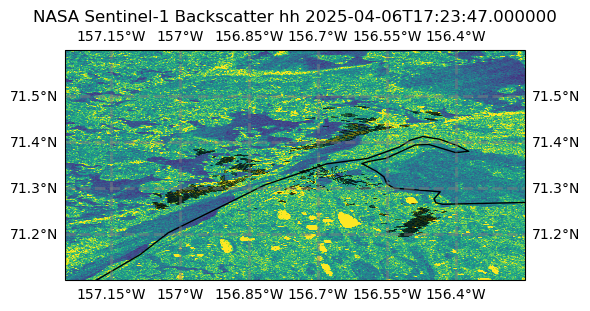

In [41]:
# Plot bounds
min_lon = -157.25
max_lon = -156.25
min_lat = 71.1
max_lat = 71.6

# Band to pick (0-indexed)
band = 0
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                      figsize=(6, 6))
ax.pcolormesh(ds['lon'].sel(band=0), ds['lat'].sel(band=0), ds['intensity'].sel(band=band),
             vmax=500)
ax.pcolormesh(lons, lats, mask, cmap="Greys_r", alpha=0.5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.labels_top = False
gl.labels_right = False
ax.set_title(f"NASA Sentinel-1 Backscatter {ds.attrs["polarizations"][band]} {str(ds["time"].values[0])}")
ax.set_xlim([min_lon, max_lon])
ax.set_ylim([min_lat, max_lat])
fig.tight_layout()

This figure takes a lot of memory. To keep this notebook running, close the figure.

In [44]:
# This figure is MASSIVE! Need to close to save memory after completing.
plt.close(fig)

Now plot the Gate ID over $Z_{e}$.

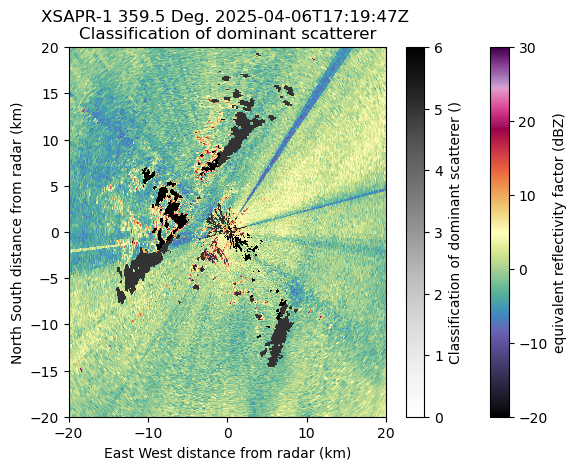

In [43]:
xmin = -20
xmax = 20
ymin = -20
ymax = 20
display = pyart.graph.RadarDisplay(radar_one)
gatefilter = pyart.filters.GateFilter(radar_one)
gatefilter.exclude_invalid('signal_to_noise_ratio')
display.plot_ppi('reflectivity', cmap='ChaseSpectral', vmin=-20, vmax=30,
                 gatefilter=gatefilter)
display.plot_ppi('gate_id', 0, mask_tuple=('gate_id', 5), cmap='Greys', alpha=1)
#plt.axis('off')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

Now plot the Gate ID over the spectrum width.

(-20.0, 20.0)

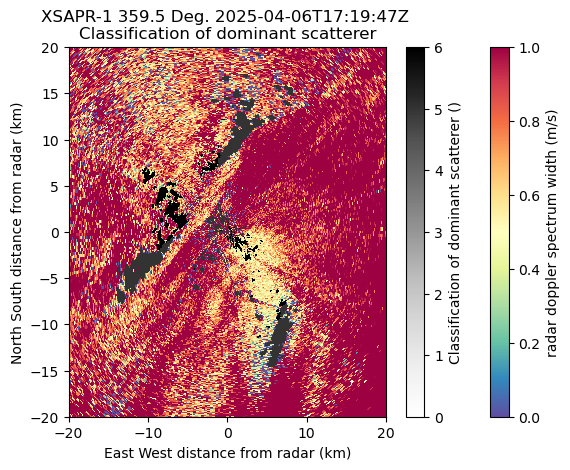

In [45]:
xmin = -20
xmax = 20
ymin = -20
ymax = 20
display = pyart.graph.RadarDisplay(radar_one)
gatefilter = pyart.filters.GateFilter(radar_one)
gatefilter.exclude_invalid('reflectivity')
display.plot_ppi('spectral_width', 0, cmap='Spectral_r', vmin=0, vmax=1,
                 gatefilter=gatefilter)
display.plot_ppi('gate_id', 0, mask_tuple=('gate_id', 5), alpha=1, cmap='Greys')
#plt.axis('off')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

Now plot the Gate ID over the $Z_{DR}$.

(-20.0, 20.0)

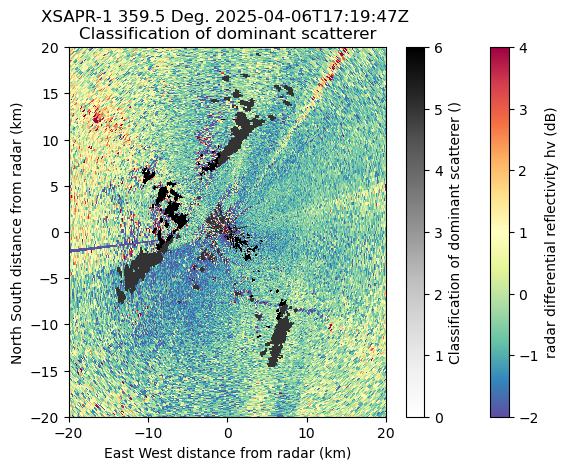

In [46]:
xmin = -20
xmax = 20
ymin = -20
ymax = 20
display = pyart.graph.RadarDisplay(radar_one)
gatefilter = pyart.filters.GateFilter(radar_one)
gatefilter.exclude_invalid('reflectivity')
display.plot_ppi('differential_reflectivity', 0, cmap='Spectral_r', vmin=-2, vmax=4,
                 gatefilter=gatefilter)
display.plot_ppi('gate_id', 0, mask_tuple=('gate_id', 5), alpha=1, cmap='Greys')
#plt.axis('off')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Second case - April 30 2025

In this case, XSAPR detected light precipitation in the presence of sea ice. The NASA Sentinel-1 data shows widespread, but thinning sea ice off of the coast of the NSA site. In this case, we will see that the sea ice mask corresponds to the thicker regions of ice over the Arctic near NSA.

In [3]:
radar_two = pyart.io.read('/gpfs/wolf2/arm/atm124/proj-shared/nsa/nsaxsaprcfrC1.a1/nsaxsaprcfrC1.a1.20250430.171947.nc')

Plot $Z_{e}$ again.

(-20.0, 20.0)

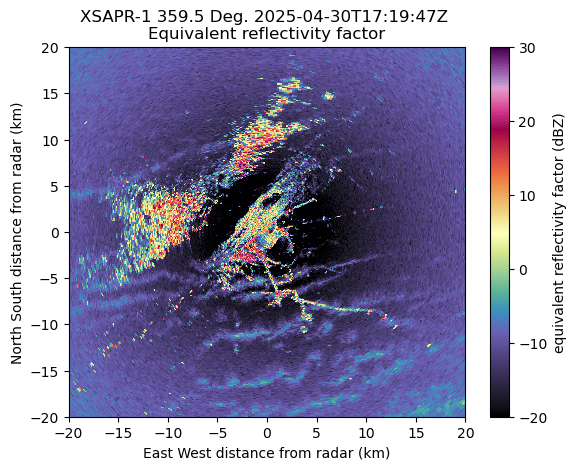

In [59]:
xmin = -20
xmax = 20
ymin = -20
ymax = 20
display = pyart.graph.RadarDisplay(radar_two)
gatefilter = pyart.filters.GateFilter(radar_two)
gatefilter.exclude_invalid('signal_to_noise_ratio')
display.plot_ppi('reflectivity', cmap='ChaseSpectral', vmin=-20, vmax=30,
                 gatefilter=gatefilter)

#plt.axis('off')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

Generate the Gate ID again.

In [9]:
# Load the sounding data
sonde = xr.open_dataset('/gpfs/wolf2/arm/atm124/proj-shared/nsa/nsasondewnpnC1.b1/nsasondewnpnC1.b1.20250430.172900.cdf')
tdry = sonde.variables["tdry"][:]
alt = sonde.variables["alt"][:]
tdry = np.insert(tdry, 0, tdry[0])
alt = np.insert(alt, 0, -9999.)

# Map the sounding data to antenna coordinates
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(
        tdry, alt, radar_two)
 
radar_two.fields["height"] = z_dict
radar_two.fields["sounding_temperature"] = temp_dict

# Retrieve the velocity texture needed by the Gate ID
texture = pyart.retrieve.calculate_velocity_texture(radar_two, vel_field="mean_doppler_velocity")
radar_two.fields["velocity_texture"] = texture

# Run the fuzzy logic algorithm
gate_id, _ = do_my_fuzz(radar_two, 'cross_correlation_ratio_hv', 'normalized_coherent_power')
gate_id

# Add the Gate ID field to the radar object
radar_two.fields["gate_id"] = gate_id

##
## CMAC calculation using fuzzy logic:
##    Doing multi_trip
##    Doing rain
##    Doing snow
##    Doing no_scatter
##    Doing melting
##    Doing sea_ice
##    Doing sea_clutter
##    Doing hard constraining melting
##     (array([], dtype=int64), array([], dtype=int64))
##    Doing hard constraining multi_trip
##     (array([], dtype=int64), array([], dtype=int64))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 1079, 1079, 1079], shape=(1081080,)), array([   0,    1,    2, ...,  998,  999, 1000], shape=(1081080,)))
##    Doing hard constraining rain
##     (array([   0,    0,    0, ..., 1079, 1079, 1079], shape=(1081080,)), array([   0,    1,    2, ...,  998,  999, 1000], shape=(1081080,)))
##    Doing hard constraining melting
##     (array([   0,    0,    0, ..., 1078, 1078, 1078], shape=(998080,)), array([  0,   1,   2, ..., 995, 996, 997], shape=(998080,)))
##    Doing hard constraining sea_ice
##     (array([ 360,  360,  360, ..., 1079, 1079, 

Load the Sentinel-1 granule for this day.

In [11]:
sentinel_path = '/gpfs/wolf2/arm/atm124/proj-shared/nsa/sentinel_1data/S1A_EW_GRDM_1SDH_20250418T172346_20250418T172446_058814_0749A9_9D68.SAFE/'
sentinel_ds = read_safe_file_to_xarray(sentinel_path, [1, 2])
sentinel_ds

(9990, 10408, 2) (9990, 10408, 2) (9990, 10408, 2)


<xarray.Dataset> Size: 4GB
Dimensions:    (lines: 9990, pixels: 10408, band: 2, time: 1)
Coordinates:
  * time       (time) datetime64[us] 8B 2025-04-18T17:23:46
Dimensions without coordinates: lines, pixels, band
Data variables:
    intensity  (lines, pixels, band) uint16 416MB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    lat        (lines, pixels, band) float64 2GB 73.56 73.56 ... 71.13 71.13
    lon        (lines, pixels, band) float64 2GB -149.5 -149.5 ... -164.8 -164.8
Attributes:
    data_level:     s
    swath_type:     ew
    data_type:      grd
    polarizations:  ['hh', 'hv']

The Gate ID looks to be favoring snow detection over sea ice over the outer regions of the mask. This shows that adjusting the membership functions for your case may be necessary. More work on constraining the membership functions is required to better distinguish between snow and sea ice.

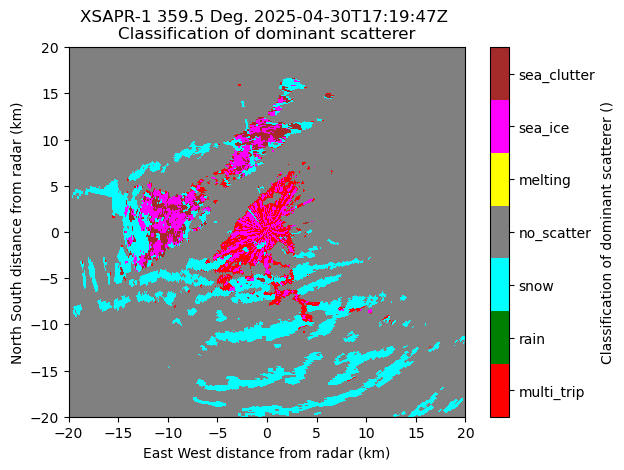

In [26]:
ax = plot_gate_id(radar_two)

Overlay the sea ice mask over the Sentinel-1 data. Some of the thicker sea ice regions within 20 km of XSAPR are detected and correspond to the thicker sea ice in the Sentinel-1 data.

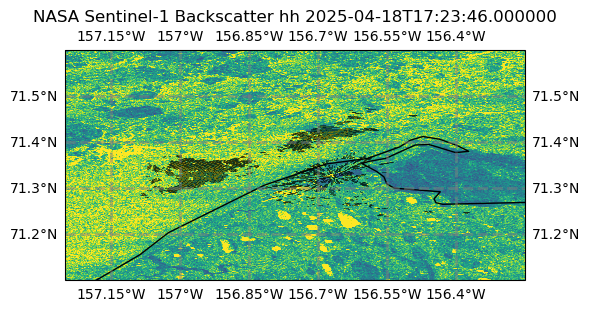

In [17]:
# Plot bounds
min_lon = -157.25
max_lon = -156.25
min_lat = 71.1
max_lat = 71.6

# Generate mask
sweep0 = radar_two.extract_sweeps([0])
lats = sweep0.gate_latitude["data"]
lons = sweep0.gate_longitude["data"]
mask = np.where(sweep0.fields["gate_id"]["data"] >= 4, 1, np.nan)

# Band to pick (0-indexed)
band = 0
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                      figsize=(6, 6))
ax.pcolormesh(sentinel_ds['lon'].sel(band=0), sentinel_ds['lat'].sel(band=0), 
              sentinel_ds['intensity'].sel(band=band),
              vmax=500)
ax.pcolormesh(lons, lats, mask, cmap="Greys_r", alpha=0.5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.labels_top = False
gl.labels_right = False
ax.set_title(f"NASA Sentinel-1 Backscatter {sentinel_ds.attrs["polarizations"][band]} {str(sentinel_ds["time"].values[0])}")
ax.set_xlim([min_lon, max_lon])
ax.set_ylim([min_lat, max_lat])
fig.tight_layout()

In [27]:
plt.close(fig)